Filename: LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    289   435R x 3C   [D, D, D]   
  2  SCI           1 ImageHDU       279   (435, 31)   float64   
  3  WHT           1 ImageHDU       279   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       279   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, D, D]   
None
Filename: LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    304   435R x 4C   [D, D, D, D]   
  2  SCI           1 ImageHDU       291   (435, 31)   float64   
  3  WHT           1 ImageHDU       291   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       291   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, 

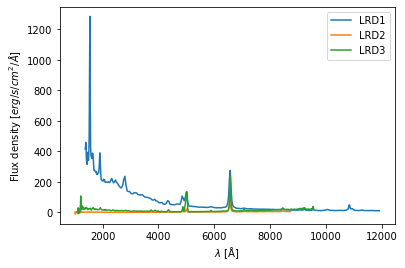

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

def LYMAN_BLANKET(lambd, z):
    #Based on Madau https://articles.adsabs.harvard.edu/pdf/1995ApJ...441...18M
    import numpy as np
    nl = 8
    p = 3.46
    npts = len(lambd)
    y = np.zeros((npts, nl), dtype=float)
    lyman = 1. - 1/(np.arange(nl) + 2)**2
    a = np.array([-0.00360, -0.00170, -0.00120, -0.00093,
                  -0.00090, -0.00087, -0.00085, -0.00080])

    c = 0.
    for i in range(nl):
        c += a[i] * ((1+z) * lyman[i])**p
    c = np.exp(c)

    lyman = 911.753 / lyman

    for i in range(nl):
        y[:, i] = a[i] * (lambd / lyman[i])**p * (lambd <= (1+z) * lyman[i])
    y = np.exp(nl * np.sum(y, axis=1) / npts)

    q = np.where(lambd <= (1+z) * lyman[nl-1])
    if len(q[0]) > 0:
        y[q] = c * np.exp(-0.0015 * z * ((1+z) * lyman[nl-1] - lambd[q]))

    return y


#Read transmission curves for g, r, J, Ks
tab = np.loadtxt('SDSS_g.data')
wave_g = tab[:,0]
transm_g = tab[:,1]

tab = np.loadtxt('SDSS_r.data')
wave_r = tab[:,0]
transm_r = tab[:,1]

tab = np.loadtxt('J_UKIRT.dat')
wave_J = 10.*tab[:,0]
transm_J = tab[:,1]/100.
wave_J = wave_J[::-1]
transm_J = transm_J[::-1]

tab = np.loadtxt('K_UKIRT.dat')
wave_Ks = 10.*tab[:,0]
transm_Ks = tab[:,1]/100.
wave_Ks = wave_Ks[::-1]
transm_Ks = transm_Ks[::-1]

#Filter characteristics from Hewett table 7
lamdacen_g = 4670.
lambdacen_r = 6156.
lambdacen_J = 1248.
lambdacen_Ks = 2201.
ABoff_g = -0.103
ABoff_r = 0.146
ABoff_J = 0.938
ABoff_Ks = 1.900

#SMC extinction parameters
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]



#Read LRD spectra
z = 3.438
#from 1.1 to 1.6
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave*10000./(1+z)
spec_lrd1 = spec1d.flux/(wave_lrd1/10000.)**2
z = 5.05
#from 1.9 to 2.5
HDU = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd2 = spec1d.wave*10000./(1+z)
spec_lrd2 = spec1d.flux/(wave_lrd2/10000.)**2
z=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000./(1+z)
spec_lrd3 = spec1d.flux/(wave_lrd3/10000.)**2

#Make plot
plt.figure()
plt.plot(wave_lrd1,spec_lrd1,zorder=1,label='LRD1')
plt.plot(wave_lrd2,spec_lrd2,zorder=1,label='LRD2')
plt.plot(wave_lrd3,spec_lrd3*10.,zorder=1,label='LRD3')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('Flux density $[erg/s/cm^2/Å]$')
plt.legend()
plt.show()

In [2]:
#PAQSsurverydata
data = np.loadtxt('PAQSsurveyphotometry.dat', skiprows=1)
ID = data[:,0]              #Rektascension fra GAIA kataloget
RA = data[:,1]              #Rektascension fra GAIA kataloget
Dec = data[:,2]             #Deklination fra GAIA kataloget

u_ATLAS = data[:,3]          # u-filter størrelsesklasse (ATLAS)
err_u_ATLAS = data[:,4]        # usikkerhed på u-filter størrelsesklasse (ATLAS)
g_ATLAS = data[:,5]          # g-filter størrelsesklasse (ATLAS)
err_g_ATLAS = data[:,6]        # usikkerhed på g-filter størrelsesklasse (ATLAS)
r_ATLAS = data[:,7]          # r-filter størrelsesklasse (ATLAS)
err_r_ATLAS = data[:,8]       # usikkerhed på r-filter størrelsesklasse (ATLAS)
i_ATLAS = data[:,9]         # i-filter størrelsesklasse (ATLAS)
err_i_ATLAS = data[:,10]       # usikkerhed på i-filter størrelsesklasse (ATLAS)
z_ATLAS = data[:,11]         # z-filter størrelsesklasse (ATLAS)
err_z_ATLAS = data[:,12]       # usikkerhed på z-filter størrelsesklasse (ATLAS)
g_DES = data[:,13]
err_g_DES = data[:,14]
r_DES = data[:,15]
err_r_DES = data[:,16]
i_DES = data[:,17]
err_i_DES = data[:,18]
z_DES = data[:,19]
err_z_DES = data[:,20]
y_DES = data[:,21]
err_y_DES = data[:,22]
y_VHS = data[:,23]
err_y_VHS = data[:,24]
j_VHS = data[:,25]
err_j_VHS = data[:,26]
h_VHS = data[:,27]
err_h_VHS = data[:,28]
ks_VHS = data[:,29]
err_ks_VHS = data[:,30]

#Lav farve-farve plottet
errlim = 0.1
good = np.where((err_g_ATLAS < errlim) & (err_r_ATLAS < errlim) & (err_j_VHS < errlim) & (err_ks_VHS < errlim))

x=j_VHS[good]-ks_VHS[good]    # VEGA
y=g_ATLAS[good]-r_ATLAS[good] # AB

<ipython-input-3-f2824ae605af>:31: RuntimeWarning: divide by zero encountered in log10
  gr[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
<ipython-input-3-f2824ae605af>:57: RuntimeWarning: divide by zero encountered in log10
  gr_av05[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
<ipython-input-3-f2824ae605af>:83: RuntimeWarning: divide by zero encountered in log10
  gr_av07[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r


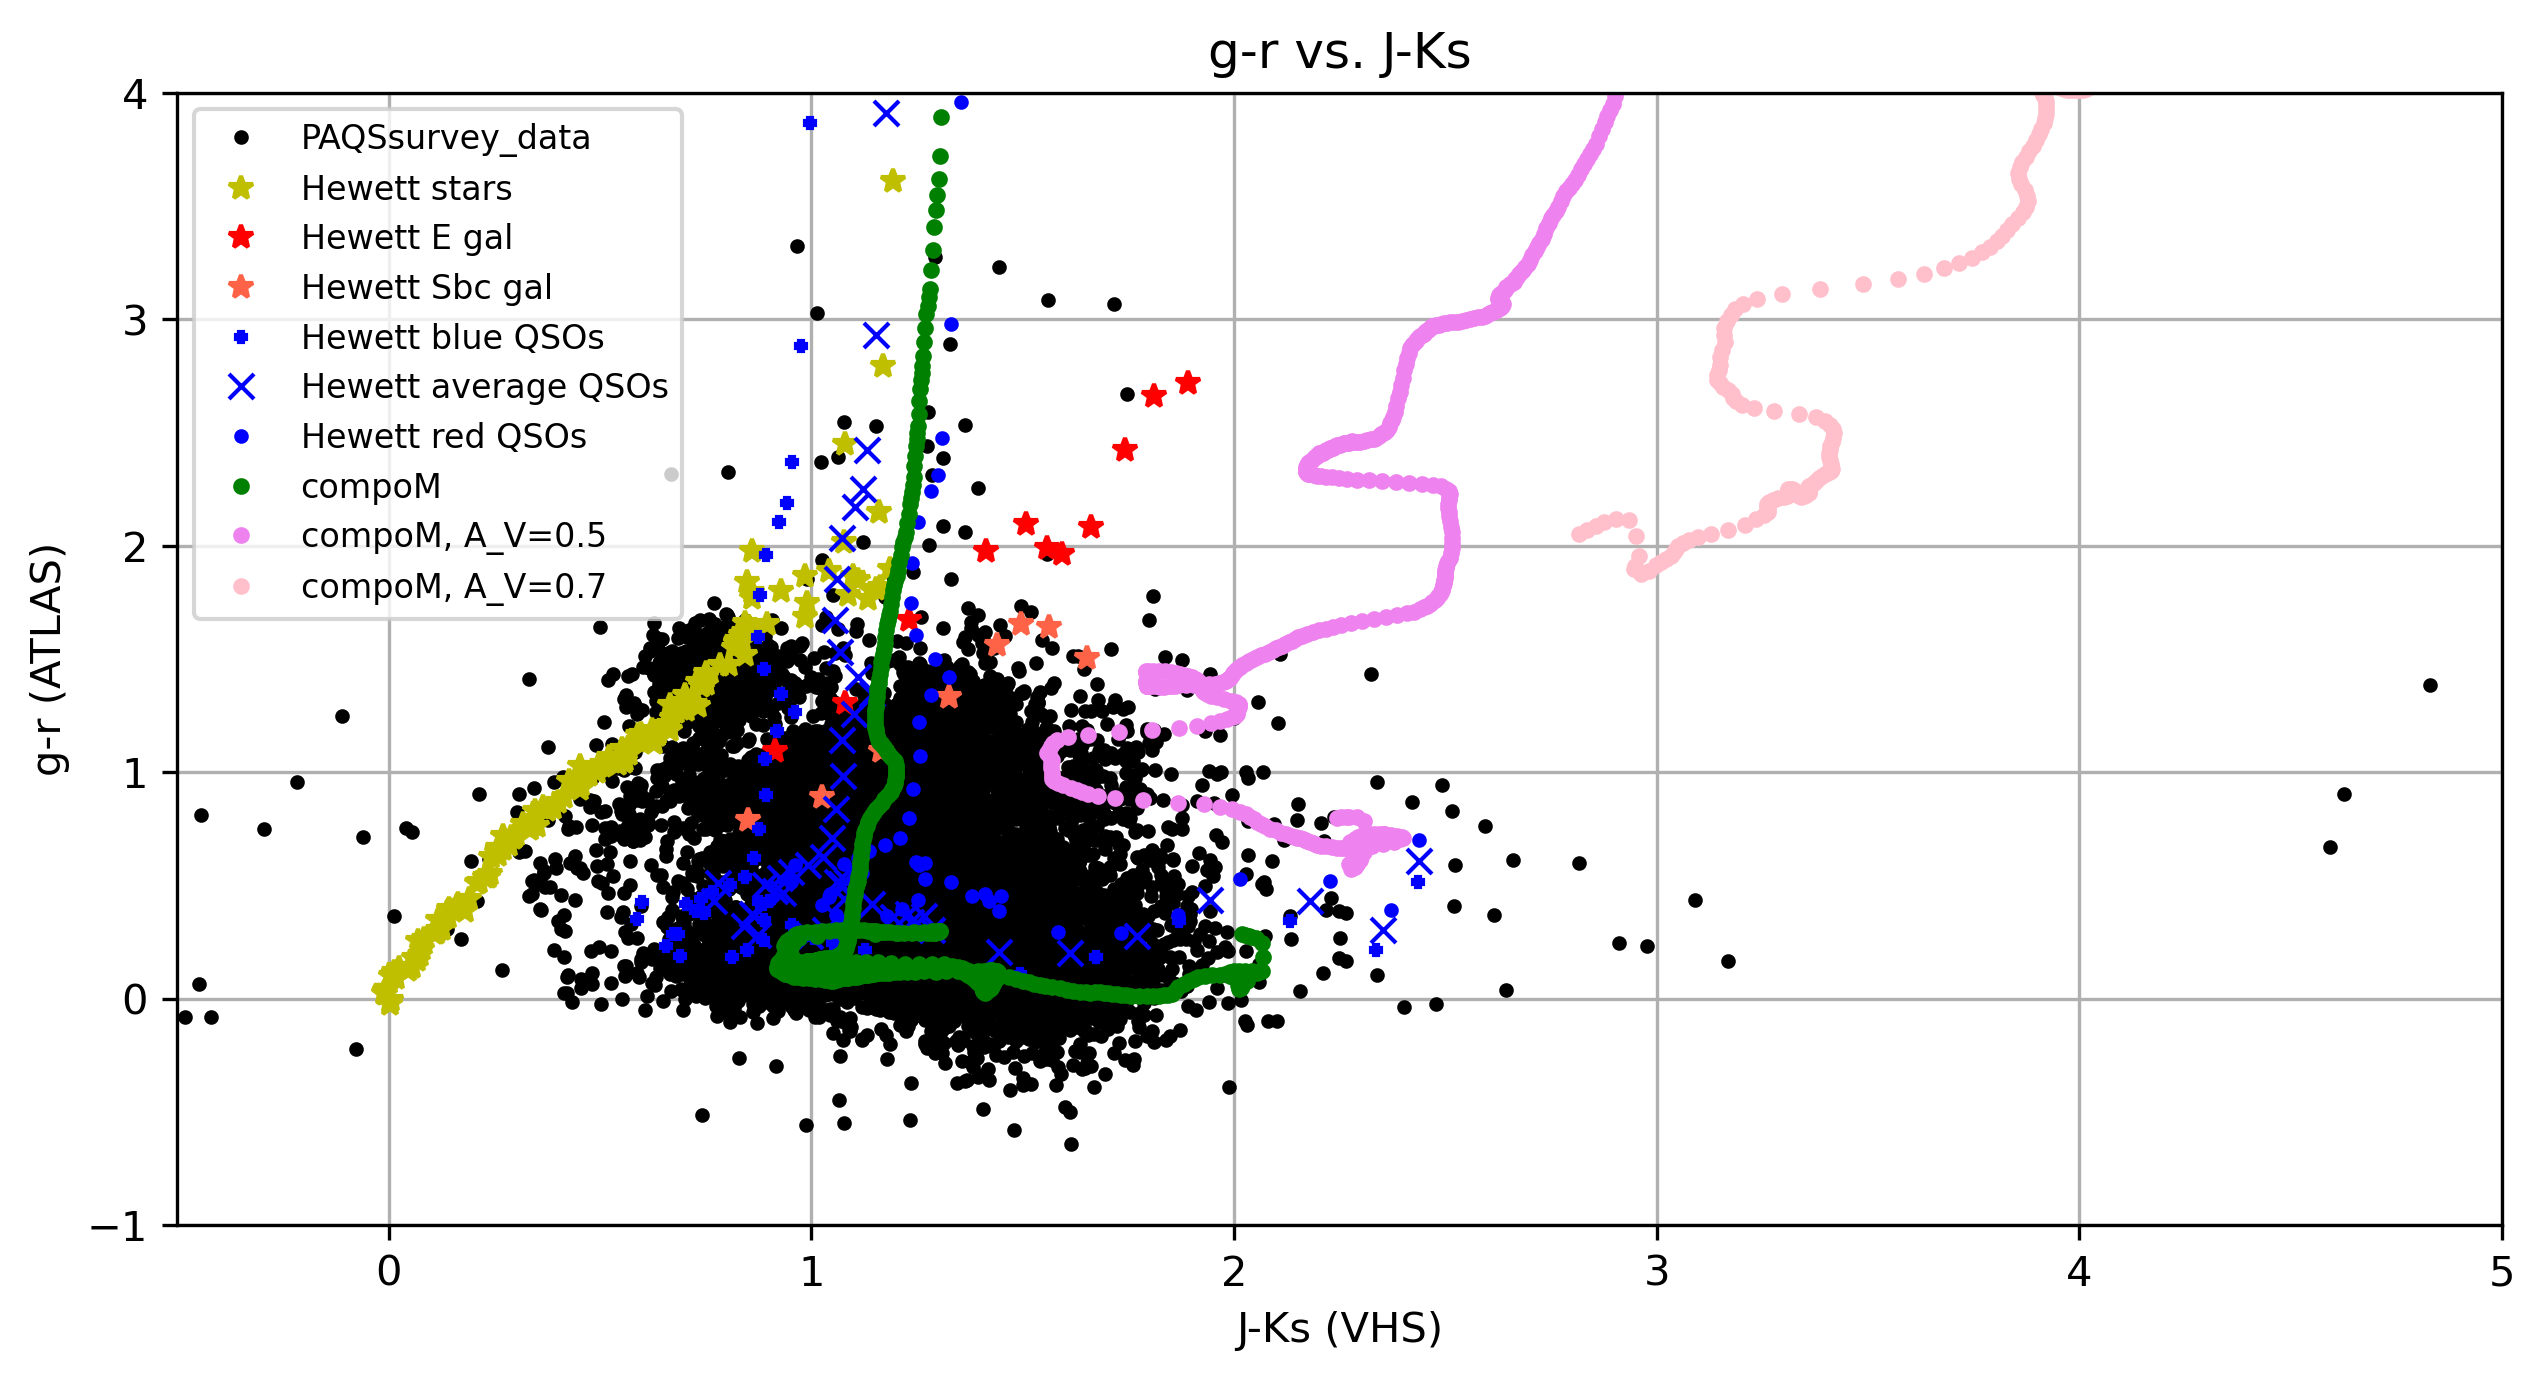

In [3]:
#Read spectrum of vega
tab = np.loadtxt('vega.dat')
wave_vega = tab[:,0]
spec_vega = tab[:,1]*1.e17

#Integrate the fluxes of vega in the four filters
spec_vega_resample_g =  spectres(wave_g,wave_vega,spec_vega*wave_vega)
gvega = spi.simps(spec_vega_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
spec_vega_resample_r =  spectres(wave_r,wave_vega,spec_vega*wave_vega)
rvega = spi.simps(spec_vega_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
spec_vega_resample_J =  spectres(wave_J,wave_vega,spec_vega*wave_vega)
Jvega = spi.simps(spec_vega_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
spec_vega_resample_Ks =  spectres(wave_Ks,wave_vega,spec_vega*wave_vega)
Ksvega = spi.simps(spec_vega_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)

#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
gr = np.empty(600, dtype=float)
JKs = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#Repeat with A_V=0.5. For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
AV = 0.5
AB = AV*4.1/3.1
wlr = wave_qso/1.e4
Alambda = spec_qso*0.
for e in range(len(ai)):
   Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
   Alambda = Alambda*AB
   spec_qso = 10**(-0.4*Alambda)*spec_qso
gr_av05 = np.empty(600, dtype=float)
JKs_av05 = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_av05[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_av05[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#Repeat with A_V=0.7. For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
AV = 0.7
AB = AV*4.1/3.1
wlr = wave_qso/1.e4
Alambda = spec_qso*0.
for e in range(len(ai)):
   Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
   Alambda = Alambda*AB
   spec_qso = 10**(-0.4*Alambda)*spec_qso
gr_av07 = np.empty(600, dtype=float)
JKs_av07 = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_av07[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_av07[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#For each z in the interval from 1.1 to 1.6 calculate the g-r and J-Ks colours for the LRD
gr_lrd1 = np.empty(76, dtype=float)
JKs_lrd1 = np.empty(76, dtype=float)
for nz in range(0,76):
    z = float(nz)/100.+1.16
    wave_lrd_z = wave_lrd1*(1.+z)
    spec_lrd = spec_lrd1*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd1[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd1[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
gr_lrd2 = np.empty(65, dtype=float)
JKs_lrd2 = np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+2.1
    wave_lrd_z = wave_lrd2*(1.+z)
    spec_lrd = spec_lrd2*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd2[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd2[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
gr_lrd3 = np.empty(65, dtype=float)
JKs_lrd3 = np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+1.7
    wave_lrd_z = wave_lrd3*(1.+z)
    spec_lrd = spec_lrd3*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd3[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd3[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

ABoff_g = -0.103
ABoff_r = 0.146

#Read Hewett et al. 
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table8.dat')
gr_8 = tab[:,1]+ABoff_g+ABoff_r
JK_8 = tab[:,7]+tab[:,8]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table16.dat')
gr_16 = tab[:,2]+ABoff_g+ABoff_r
JK_16 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table17.dat')
gr_17 = tab[:,2]+ABoff_g+ABoff_r
JK_17 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table25.dat')
gr_25 = tab[:,2]+ABoff_g+ABoff_r
JK_25 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table26.dat')
gr_26 = tab[:,2]+ABoff_g+ABoff_r
JK_26 = tab[:,8]+tab[:,9]
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table27.dat')
gr_27 = tab[:,2]+ABoff_g+ABoff_r
JK_27 = tab[:,8]+tab[:,9]


#Make plot
plt.figure(dpi=300,figsize=(10,5))
plt.title('g-r vs. J-Ks')
plt.plot(x,y,'o',color='black',markersize=2.5,label='PAQSsurvey_data')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JK_16, gr_16, '*',color='r', label='Hewett E gal')
plt.plot(JK_17, gr_17, '*',color='tomato', label='Hewett Sbc gal')
plt.plot(JK_25, gr_25, 'P',color='b', markersize=2.5, label='Hewett blue QSOs')
plt.plot(JK_26, gr_26, 'x',color='b', label='Hewett average QSOs')
plt.plot(JK_27, gr_27, 'o',color='b',markersize=2.5, label='Hewett red QSOs')
plt.plot(JKs, gr, '.',color='g', label='compoM')
plt.plot(JKs_av05, gr_av05, '.',color='violet', label='compoM, A_V=0.5')
plt.plot(JKs_av07, gr_av07, '.',color='pink', label='compoM, A_V=0.7')
#plt.plot(JKs_lrd1, gr_lrd1, '.',color='cyan', label='LRD1')
#plt.plot(JKs_lrd2, gr_lrd2, '.',color='orange', label='LRD2')
#plt.plot(JKs_lrd3, gr_lrd3, '.',color='greenyellow', label='LRD3')
plt.xlabel('J-Ks (VHS)')
plt.ylabel('g-r (ATLAS)')
plt.grid()
plt.xlim(-0.5,5)
plt.ylim(-1,4)
plt.legend(prop={'size':8})


plt.savefig('comp_w_Av.png', bbox_inches='tight')
plt.show()
plt.close()

## Making a template of reddened quasar in i galaxy and Sbc galaxy:

In [4]:
#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)

#QSO with I gal
AVqso = 4.5
ABqso = AVqso*4.1/3.1

#QSO with Sbc gal
AVqso2 = 1.5
ABqso2 = AVqso2*4.1/3.1

#Redden the qso template with I gal
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model_qso = 10**(-0.4*Alambda)*spec_qso


#Redden the qso template with Sbc gal
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda2 = Alambda*ABqso2
model_qso2 = 10**(-0.4*Alambda2)*spec_qso

AV_Igal = 0.0
AB_Igal = AV_Igal*4.1/3.1

#Redden the I gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda_I = Alambda*AB_Igal
spec_I_rebin = 10**(-0.4*Alambda_I)*spec_I_rebin

AV_Sbcgal = 3
AB_Sbcgal = AV_Sbcgal*4.1/3.1

#Redden the Sbc gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda_Sbc = Alambda*AB_Sbcgal
spec_Sbc_rebin = 10**(-0.4*Alambda_Sbc)*spec_Sbc_rebin

#Normalise with I gal
specfilt = np.nonzero((wave_lrd2 > 5250) & (wave_lrd2 < 5600))
normspec = np.mean(spec_lrd2[specfilt])
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model_qso[modelfilt])
normgal = np.mean(spec_I_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_Igal = (3.*model_qso*factorqso+1.*spec_I_rebin*factorgal)/4.

#Normalise with Sbc gal
specfilt = np.nonzero((wave_lrd2 > 5200) & (wave_lrd2 < 5500))
normspec = np.mean(spec_lrd2[specfilt])
modelfilt = np.nonzero((wave_qso > 5200) & (wave_qso < 5500))
normqso2 = np.mean(model_qso2[modelfilt])
normgal2 = np.mean(spec_Sbc_rebin[modelfilt])
factorqso2 = normspec/normqso2
factorgal2 = normspec/normgal2
model_Sbcgal = (model_qso2*factorqso2+spec_Sbc_rebin*factorgal2)/2.


In [5]:
#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours for qso + i galaxy
gr_igal = np.empty(60, dtype=float)
JKs_igal = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    model_Igal = model_Igal*LYMAN_BLANKET(wave_qso_z,z)
    model_resample_g =  spectres(wave_g,wave_qso_z,model_Igal*wave_qso_z)
    model_resample_r =  spectres(wave_r,wave_qso_z,model_Igal*wave_qso_z)
    model_resample_J =  spectres(wave_J,wave_qso_z,model_Igal*wave_qso_z)
    model_resample_Ks =  spectres(wave_Ks,wave_qso_z,model_Igal*wave_qso_z)
    gflam = spi.simps(model_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(model_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(model_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(model_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_igal[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_igal[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
    
    
#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours for qso + Sbc galaxy
gr_Sbcgal = np.empty(60, dtype=float)
JKs_Sbcgal = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    model_Sbcgal = model_Sbcgal*LYMAN_BLANKET(wave_qso_z,z)
    model_resample_g2 =  spectres(wave_g,wave_qso_z,model_Sbcgal*wave_qso_z)
    model_resample_r2 =  spectres(wave_r,wave_qso_z,model_Sbcgal*wave_qso_z)
    model_resample_J2 =  spectres(wave_J,wave_qso_z,model_Sbcgal*wave_qso_z)
    model_resample_Ks2 =  spectres(wave_Ks,wave_qso_z,model_Sbcgal*wave_qso_z)
    gflam = spi.simps(model_resample_g2*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(model_resample_r2*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(model_resample_J2*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(model_resample_Ks2*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_Sbcgal[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_Sbcgal[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)


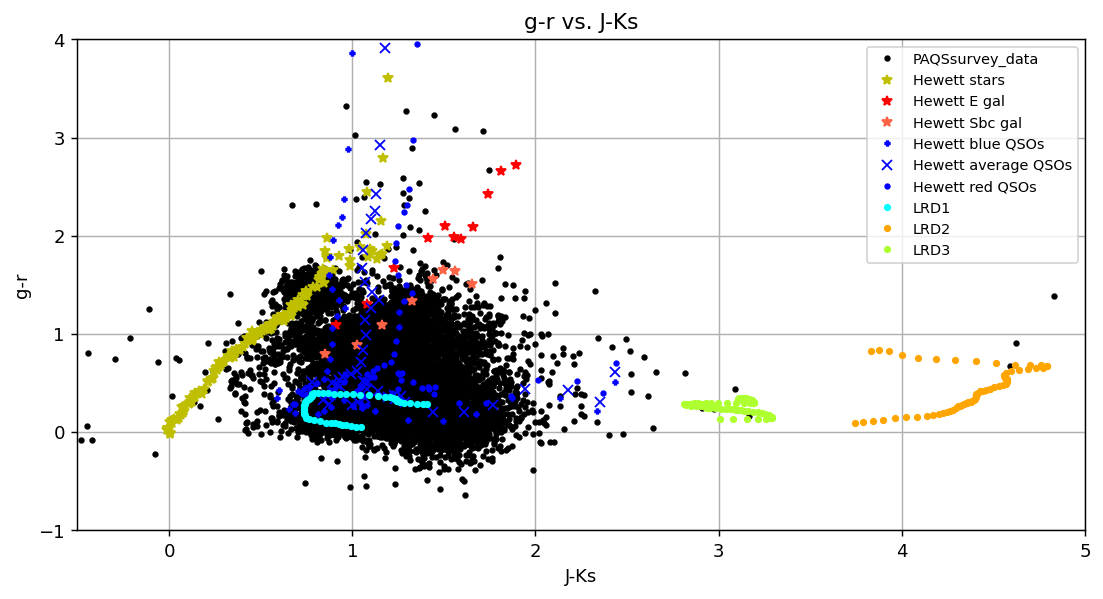

In [6]:
#Make plot
plt.figure(dpi=130,figsize=(10,5))
plt.title('g-r vs. J-Ks')
plt.plot(x,y,'o',color='black',markersize=2.5,label='PAQSsurvey_data')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JK_16, gr_16, '*',color='r', label='Hewett E gal')
plt.plot(JK_17, gr_17, '*',color='tomato', label='Hewett Sbc gal')
plt.plot(JK_25, gr_25, 'P',color='b', markersize=2.5, label='Hewett blue QSOs')
plt.plot(JK_26, gr_26, 'x',color='b', label='Hewett average QSOs')
plt.plot(JK_27, gr_27, 'o',color='b',markersize=2.5, label='Hewett red QSOs')
#plt.plot(JKs, gr, '.',color='g', label='compoM')
#plt.plot(JKs_av05, gr_av05, '.',color='violet', label='compoM, A_V=0.5')
#plt.plot(JKs_av07, gr_av07, '.',color='pink', label='compoM, A_V=0.7')
plt.plot(JKs_lrd1, gr_lrd1, '.',color='cyan', label='LRD1')
plt.plot(JKs_lrd2, gr_lrd2, '.',color='orange', label='LRD2')
plt.plot(JKs_lrd3, gr_lrd3, '.',color='greenyellow', label='LRD3')
#plt.plot(JKs_igal, gr_igal, '*',color='deeppink', label='compoM with I galaxy')
#plt.plot(JKs_Sbcgal, gr_Sbcgal, '*',color='lime', label='compoM with Sbc galaxy')
plt.xlabel('J-Ks')
plt.ylabel('g-r')
plt.grid()
plt.xlim(-0.5,5)
plt.ylim(-1,4)
plt.legend(prop={'size':8})

plt.savefig('lrd.png', bbox_inches='tight')
plt.show()
plt.close()

## Making ellipses around stars and quasars:

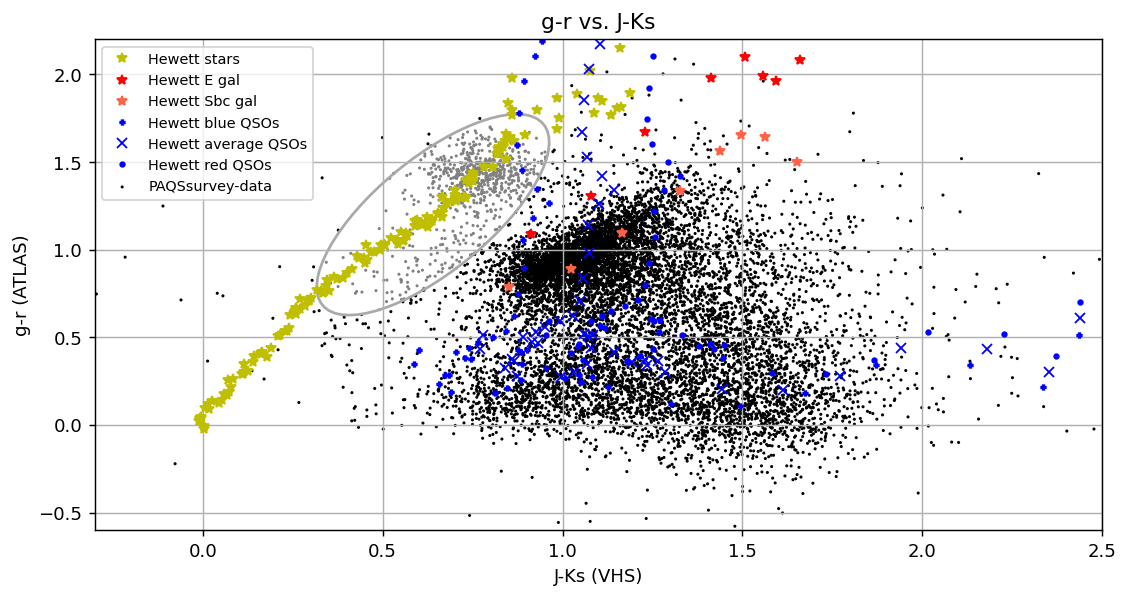

In [7]:
import matplotlib.patches as patches
from matplotlib.patches import Ellipse


#PAQSsurverydata
data = np.loadtxt('PAQSsurveyphotometry.dat', skiprows=1)
ID = data[:,0]              #Rektascension fra GAIA kataloget
RA = data[:,1]              #Rektascension fra GAIA kataloget
Dec = data[:,2]             #Deklination fra GAIA kataloget

u_ATLAS = data[:,3]          # u-filter størrelsesklasse (ATLAS)
err_u_ATLAS = data[:,4]        # usikkerhed på u-filter størrelsesklasse (ATLAS)
g_ATLAS = data[:,5]          # g-filter størrelsesklasse (ATLAS)
err_g_ATLAS = data[:,6]        # usikkerhed på g-filter størrelsesklasse (ATLAS)
r_ATLAS = data[:,7]          # r-filter størrelsesklasse (ATLAS)
err_r_ATLAS = data[:,8]       # usikkerhed på r-filter størrelsesklasse (ATLAS)
i_ATLAS = data[:,9]         # i-filter størrelsesklasse (ATLAS)
err_i_ATLAS = data[:,10]       # usikkerhed på i-filter størrelsesklasse (ATLAS)
z_ATLAS = data[:,11]         # z-filter størrelsesklasse (ATLAS)
err_z_ATLAS = data[:,12]       # usikkerhed på z-filter størrelsesklasse (ATLAS)
g_DES = data[:,13]
err_g_DES = data[:,14]
r_DES = data[:,15]
err_r_DES = data[:,16]
i_DES = data[:,17]
err_i_DES = data[:,18]
z_DES = data[:,19]
err_z_DES = data[:,20]
y_DES = data[:,21]
err_y_DES = data[:,22]
y_VHS = data[:,23]
err_y_VHS = data[:,24]
j_VHS = data[:,25]
err_j_VHS = data[:,26]
h_VHS = data[:,27]
err_h_VHS = data[:,28]
ks_VHS = data[:,29]
err_ks_VHS = data[:,30]

#Lav farve-farve plottet
errlim = 0.1
good = np.where((err_g_ATLAS < errlim) & (err_r_ATLAS < errlim) & (err_j_VHS < errlim) & (err_ks_VHS < errlim))

x=j_VHS[good]-ks_VHS[good]    # VEGA
y=g_ATLAS[good]-r_ATLAS[good] # AB


plt.figure(dpi=130,figsize=(10,5))
plt.title('g-r vs. J-Ks')
plt.xlabel('J-Ks (VHS)')
plt.ylabel('g-r (ATLAS)')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JK_16, gr_16, '*',color='r', label='Hewett E gal')
plt.plot(JK_17, gr_17, '*',color='tomato', label='Hewett Sbc gal')
plt.plot(JK_25, gr_25, 'P',color='b', markersize=2.5, label='Hewett blue QSOs')
plt.plot(JK_26, gr_26, 'x',color='b', label='Hewett average QSOs')
plt.plot(JK_27, gr_27, 'o',color='b',markersize=2.5, label='Hewett red QSOs')

# Ellipse til stjerner
s_ell_center = (0.64, 1.2)
s_ell_width = 0.41
s_ell_height = 1.25
s_angle=335
s_ellipse = patches.Ellipse(s_ell_center, s_ell_width, s_ell_height, angle=s_angle, fill=False, edgecolor='darkgrey', linewidth=1.5)

ax = plt.gca()

ax.add_patch(s_ellipse)

cos_angle_s = np.cos(np.radians(180.-s_angle))
sin_angle_s = np.sin(np.radians(180.-s_angle))

xc_s = x - s_ell_center[0]
yc_s = y - s_ell_center[1]

xct_s = xc_s * cos_angle_s - yc_s * sin_angle_s
yct_s = xc_s * sin_angle_s + yc_s * cos_angle_s 

rad_cc_s = (xct_s**2/(s_ell_width/2.)**2) + (yct_s**2/(s_ell_height/2.)**2)

# Set the colors. Black if outside the ellipse, grey if inside
colors_array = []

for r in rad_cc_s:
    if r <= 1.:
        # point in star ellipse
        colors_array.append('grey')
    else:
        # point not in ellipse
        colors_array.append('black')
       
plt.scatter(x, y, c=colors_array,label='PAQSsurvey-data',s=0.5)

plt.xlim(-0.3,2.5)
plt.ylim(-0.6,2.2)
plt.grid()
plt.legend(prop={'size':8})
plt.savefig('ellipse_star.png')  

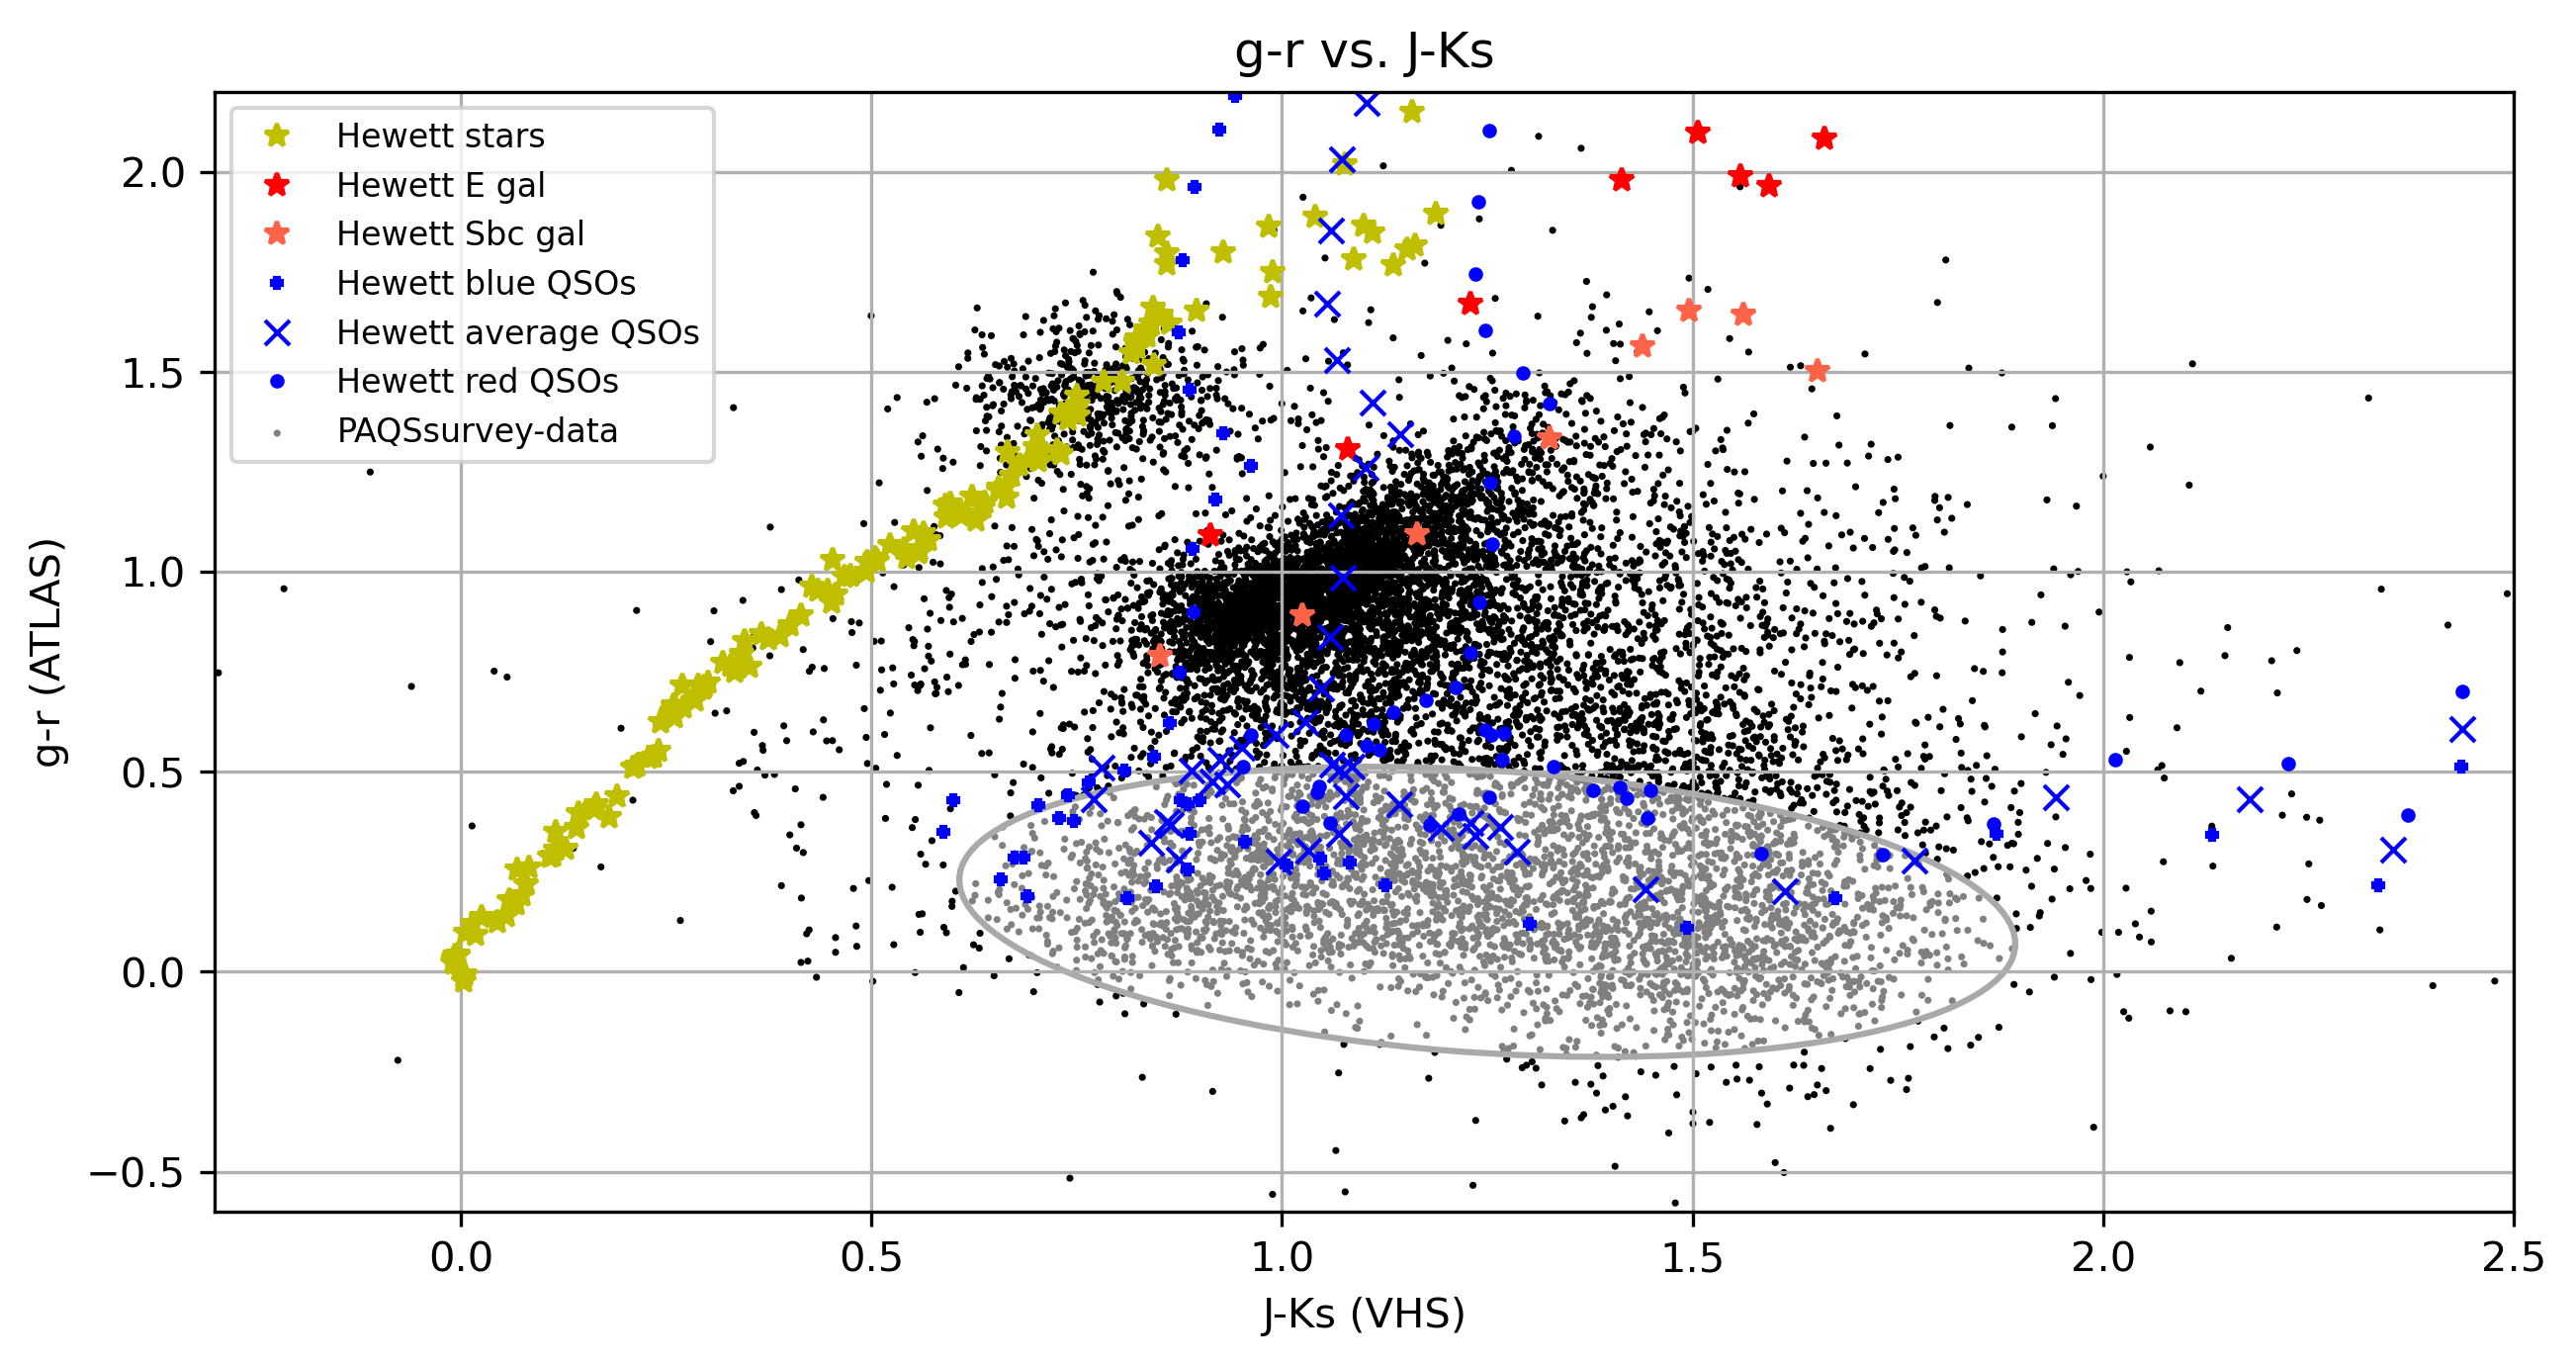

In [8]:
plt.figure(dpi=300,figsize=(10,5))
plt.title('g-r vs. J-Ks')
plt.xlabel('J-Ks (VHS)')
plt.ylabel('g-r (ATLAS)')
#plt.plot(x,y,'o',color='black',markersize=2.5,label='PAQSsurvey_data')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JK_16, gr_16, '*',color='r', label='Hewett E gal')
plt.plot(JK_17, gr_17, '*',color='tomato', label='Hewett Sbc gal')
plt.plot(JK_25, gr_25, 'P',color='b', markersize=2.5, label='Hewett blue QSOs')
plt.plot(JK_26, gr_26, 'x',color='b', label='Hewett average QSOs')
plt.plot(JK_27, gr_27, 'o',color='b',markersize=2.5, label='Hewett red QSOs')


# Ellipse til kvasarer:
k_ell_center = (1.25, 0.15)
k_ell_width = 0.7
k_ell_height = 1.3
k_angle=260
k_ellipse = patches.Ellipse(k_ell_center, k_ell_width, k_ell_height, angle=k_angle, fill=False, edgecolor='darkgrey', linewidth=1.5)

ax = plt.gca()

ax.add_patch(k_ellipse)

cos_angle_k = np.cos(np.radians(180.-k_angle))
sin_angle_k = np.sin(np.radians(180.-k_angle))

xc_k = x - k_ell_center[0]
yc_k = y - k_ell_center[1]

xct_k = xc_k * cos_angle_k - yc_k * sin_angle_k
yct_k = xc_k * sin_angle_k + yc_k * cos_angle_k

rad_cc_k = (xct_k**2/(k_ell_width/2.)**2) + (yct_k**2/(k_ell_height/2.)**2)


# Set the colors. Black if outside the ellipse, grey if inside
colors_array3 = []

for r in rad_cc_k:
    if r <= 1.:
        # point in kvasar ellipse
        colors_array3.append('grey')
    else:
        # point not in ellipse
        colors_array3.append('black')
       
plt.scatter(x, y, c=colors_array3,label='PAQSsurvey-data',s=0.5)


plt.xlim(-0.3,2.5)
plt.ylim(-0.6,2.2)
plt.grid()
plt.legend(prop={'size':8})

plt.savefig('ellipse_quasar.png', bbox_inches='tight')

In [9]:
def point_inside_ellipse_s(x_func, y_func, h, k, a, b):
    """
    Check if a point (x, y) lies inside the ellipse
    centered at (h, k) with width 2a and height 2b.
    """
    return ((x_func - h) ** 2) / (a ** 2) + ((y_func - k) ** 2) / (b ** 2) <= 1


# Define the parameters of the ellipse for stars
h = 0.64
k = 1.2
a = s_ell_width / 2  # semi-major axis
b = s_ell_height / 2  # semi-minor axis

# Count the number of points inside the ellipse
num_points_inside_s = 0
for x_func, y_func in zip(x, y):
    if point_inside_ellipse_s(x_func, y_func, h, k, a, b):
        num_points_inside_s += 1


def point_inside_ellipse_k(x_func_k, y_func_k, h_k, k_k, a_k, b_k):
    """
    Check if a point (x, y) lies inside the ellipse
    centered at (h, k) with width 2a and height 2b.
    """
    return ((x_func_k - h_k) ** 2) / (a_k ** 2) + ((y_func_k - k_k) ** 2) / (b_k ** 2) <= 1

# Define the parameters of the ellipse for quasars
h_k = 1.25
k_k = 0.15
a_k = k_ell_width / 2  # semi-major axis
b_k = k_ell_height / 2  # semi-minor axis

# Count the number of points inside the ellipse
num_points_inside_k = 0
for x_func_k, y_func_k in zip(x, y):
    if point_inside_ellipse_k(x_func_k, y_func_k, h_k, k_k, a_k, b_k):
        num_points_inside_k += 1

print("Number of points inside the quasar ellipse:", num_points_inside_k)

print("Number of points inside the star ellipse:", num_points_inside_s)

Number of points inside the quasar ellipse: 3553
Number of points inside the star ellipse: 633


In [10]:
total=len(x)
print("Antal kilder:",total)
print("Procentdel af dem som er stjerner:",(num_points_inside_s/total)*100)
print("Procentdel af dem som er kvasarer:",(num_points_inside_k/total)*100)

Antal kilder: 11172
Procentdel af dem som er stjerner: 5.665950590762621
Procentdel af dem som er kvasarer: 31.802721088435376


## Prøver at indsætte linje der skelner stjerner fra kvasarer men virker ik

(-0.6, 2.0)

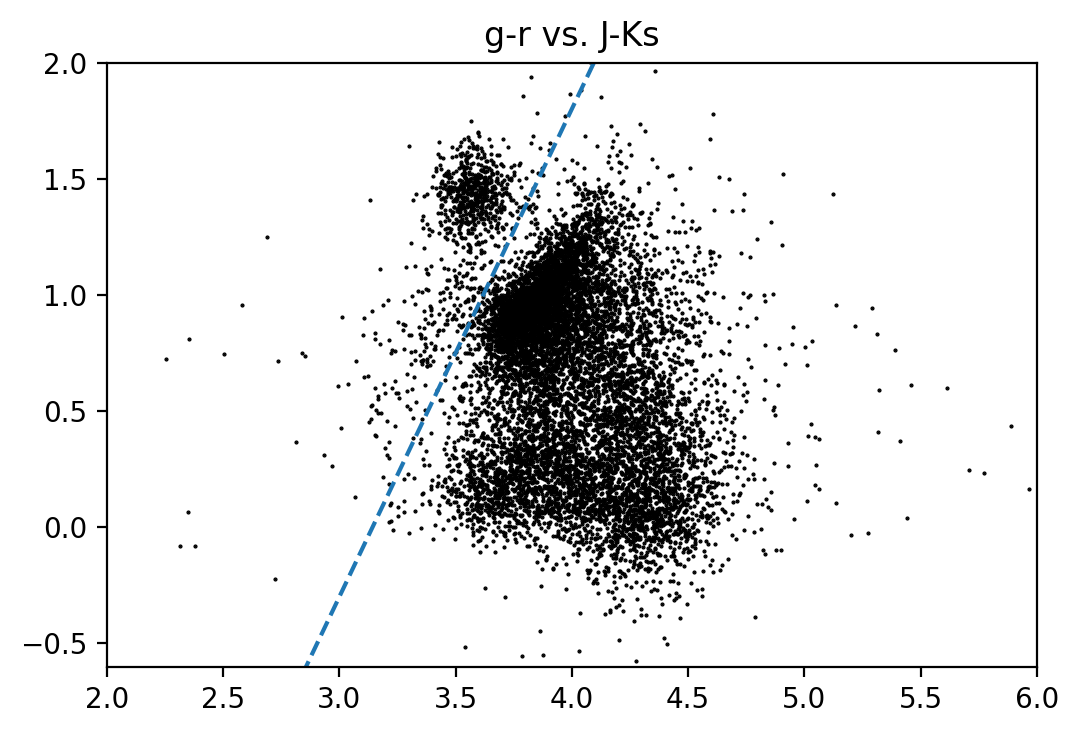

In [11]:
x_lin=np.linspace(2,6,1000)
y_lin=2.1*x_lin+1.2-7.8 #forskrift fundet i artikel for g-r vs- J-Ks


x=j_VHS[good]+0.938-ks_VHS[good]+1.86   # AB
#x=j_VHS[good]-ks_VHS[good] 
y=g_ATLAS[good]-r_ATLAS[good] # AB

plt.figure(dpi=200)
plt.title('g-r vs. J-Ks')
plt.plot(x,y,'o',color='black',markersize=0.5,label='PAQSsurvey_data')
plt.plot(x_lin,y_lin,linestyle ='dashed')

plt.xlim(2,6)
plt.ylim(-0.6,2)


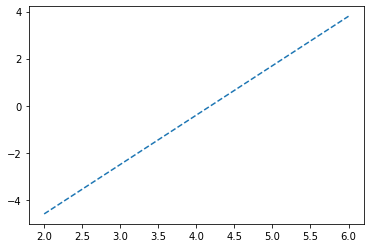

In [12]:
y_lin=2.1*x_lin+1.2-10
plt.plot(x_lin,y_lin,linestyle ='dashed')
#plt.xlim(2,6)
#plt.ylim(-0.6,2)

## Prøver at laver en colorbar med rødforskydninger

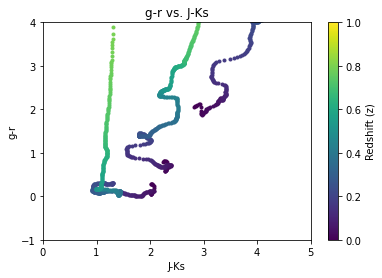

In [13]:
# Define a colormap
cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer

# Plot the data points with different colors based on redshift (z)
for i in range(len(gr)):
    plt.plot(JKs[i], gr[i], '.', color=cmap(i / len(gr)), label=f'z={i/10:.1f}')
    plt.plot(JKs_av05[i], gr_av05[i], '.', color=cmap(i / len(gr_av05)), label=f'z={i/10:.1f}')
    plt.plot(JKs_av07[i], gr_av07[i], '.', color=cmap(i / len(gr_av07)), label=f'z={i/10:.1f}')
    plt.xlabel('J-Ks')
    plt.ylabel('g-r')
    plt.xlim(-0.0,5)
    plt.ylim(-1,4)
    plt.title('g-r vs. J-Ks')

# Similarly, plot the other data points with different colors based on redshift (z)
# Repeat the above process for other datasets

# Include color bar for reference
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
cbar.set_label('Redshift (z)')




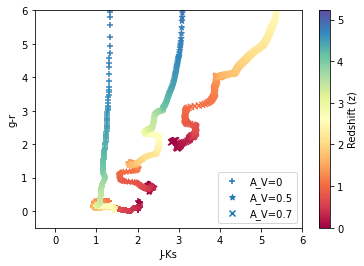

In [14]:
# Define the redshift values
z_values = np.arange(0, 6, 0.01)

# Create a scatter plot with redshift values as colors
plt.scatter(JKs, gr, c=z_values, marker='+', cmap='Spectral', label='A_V=0')
plt.scatter(JKs_av05, gr_av05,c=z_values, marker='*', cmap='Spectral', label='A_V=0.5')
plt.scatter(JKs_av07, gr_av07, c=z_values, marker='x', cmap='Spectral', label='A_V=0.7')

# Add colorbar
cbar = plt.colorbar(label='Redshift (z)')

# Add other plotting parameters
plt.xlabel('J-Ks')
plt.ylabel('g-r')
plt.xlim(-0.5, 6)
plt.ylim(-0.5, 6)
plt.legend()
plt.show()

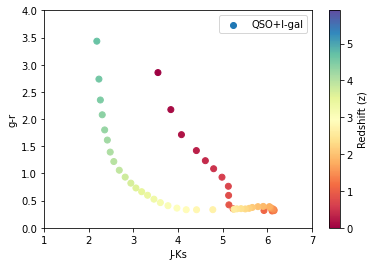

In [15]:
# Define the redshift values
z_values = np.arange(0, 6, 0.1)

# Create a scatter plot with redshift values as colors
plt.scatter(JKs_igal, gr_igal, c=z_values, cmap='Spectral', label='QSO+I-gal')

# Add colorbar
cbar = plt.colorbar(label='Redshift (z)')

# Add other plotting parameters
plt.xlabel('J-Ks')
plt.ylabel('g-r')
plt.xlim(1, 7)
plt.ylim(0, 4)
plt.legend()
plt.show()

In [16]:
print(RA)

[ 12.83712163  12.77789532  12.94422841 ... 336.4642328   12.86630166
  50.46660019]


In [17]:
print(Dec)

[-27.13461292 -27.12698118 -27.15583525 ... -59.76163079 -68.12783268
 -58.88757365]


In [18]:
print(ID)

[2.34267215e+18 2.34285979e+18 2.34267682e+18 ... 6.40813793e+18
 4.70432352e+18 4.72391269e+18]
